### Basic Random Forest

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
glob = __import__('glob')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. Set the path to your unzipped data root directory
#    Adjust this to where you extracted the dataset (subfolders per fault type)
data_dir = '/Users/bryant_lue/Downloads/full'

# 2. Feature extraction function: computes simple time-domain stats per channel
def extract_features(file_path):
    df = pd.read_csv(file_path, header=None)
    stats = []
    for col in df.columns:
        col_data = df[col]
        stats.extend([
            col_data.mean(),
            col_data.std(),
            col_data.min(),
            col_data.max(),
            col_data.median()
        ])
    return stats

# 3. Prepare feature names (5 stats × 8 channels = 40 features)
stats_names = ['mean', 'std', 'min', 'max', 'median']
feature_names = []
for ch in range(1, 9):
    for s in stats_names:
        feature_names.append(f"{s}_ch{ch}")

# 4. Walk through subdirectories, extract features and labels
label_mapping = {
    'normal': 0,
    'imbalance': 1,
    'horizontal_misalignment': 2,
    'vertical_misalignment': 3,
    'overhang_ball': 4,
    'overhang_cage': 5,
    'overhang_race': 6,
    'underhang_ball': 7,
    'underhang_cage': 8,
    'underhang_race': 9,
}


from pathlib import Path

label_mapping = {
    'normal': 0,
    'imbalance': 1,
    'horizontal_misalignment': 2,
    'vertical_misalignment': 3,
    'overhang_ball': 4,
    'overhang_cage': 5,
    'overhang_race': 6,
    'underhang_ball': 7,
    'underhang_cage': 8,
    'underhang_race': 9,
}

fault_name_mapping = {
    'ball_fault': 'ball',
    'cage_fault': 'cage',
    'outer_race': 'race',
}

file_label_pairs = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.csv'):
            full_path = os.path.join(root, file)
            parts = Path(full_path).parts

            found = False

            # Try single-folder match
            for part in parts:
                label = part.replace(' ', '_').replace('-', '_').lower()
                if label in label_mapping:
                    file_label_pairs.append((full_path, label))
                    found = True
                    break

            # Try parent + normalized fault name combo
            if not found:
                for i in range(len(parts) - 1):
                    parent = parts[i].replace(' ', '_').replace('-', '_').lower()
                    fault_folder = parts[i + 1].replace(' ', '_').replace('-', '_').lower()
                    if fault_folder in fault_name_mapping:
                        fault = fault_name_mapping[fault_folder]
                        joined_label = f"{parent}_{fault}"
                        if joined_label in label_mapping:
                            file_label_pairs.append((full_path, joined_label))
                            found = True
                            break

            if not found:
                raise ValueError(f"Label not in label_mapping for path: {full_path}")

X, y = [], []
for fp, label in tqdm(file_label_pairs, desc="Extracting features", unit="file"):
    if label not in label_mapping:
        raise ValueError(f"Unrecognized label: {label}")
    X.append(extract_features(fp))
    y.append(label_mapping[label])

print(f"Extracted {len(X)} samples with {len(feature_names)} features each.")

# Convert to arrays/DataFrame
X = np.array(X)
y = np.array(y)
df = pd.DataFrame(X, columns=feature_names)
df['label'] = y

# 5. Train/test split and scaling
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_names].values,
    df['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 6. Fit a Random Forest multiclass classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

### Basic Random Forest Performance Evaluation

                         precision    recall  f1-score   support

                 normal       0.90      0.90      0.90        10
              imbalance       0.97      0.97      0.97        67
horizontal_misalignment       0.95      0.95      0.95        39
  vertical_misalignment       1.00      0.98      0.99        60
          overhang_ball       1.00      1.00      1.00        27
          overhang_cage       0.95      1.00      0.97        38
          overhang_race       1.00      0.97      0.99        38
         underhang_ball       1.00      1.00      1.00        37
         underhang_cage       1.00      1.00      1.00        38
         underhang_race       1.00      1.00      1.00        37

               accuracy                           0.98       391
              macro avg       0.98      0.98      0.98       391
           weighted avg       0.98      0.98      0.98       391



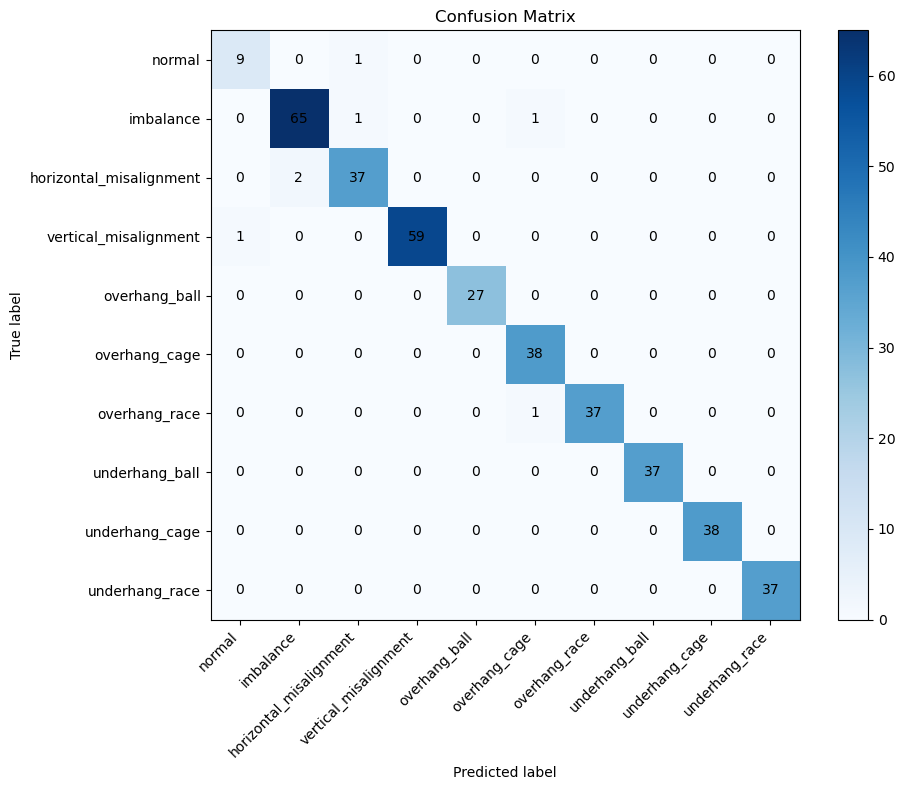

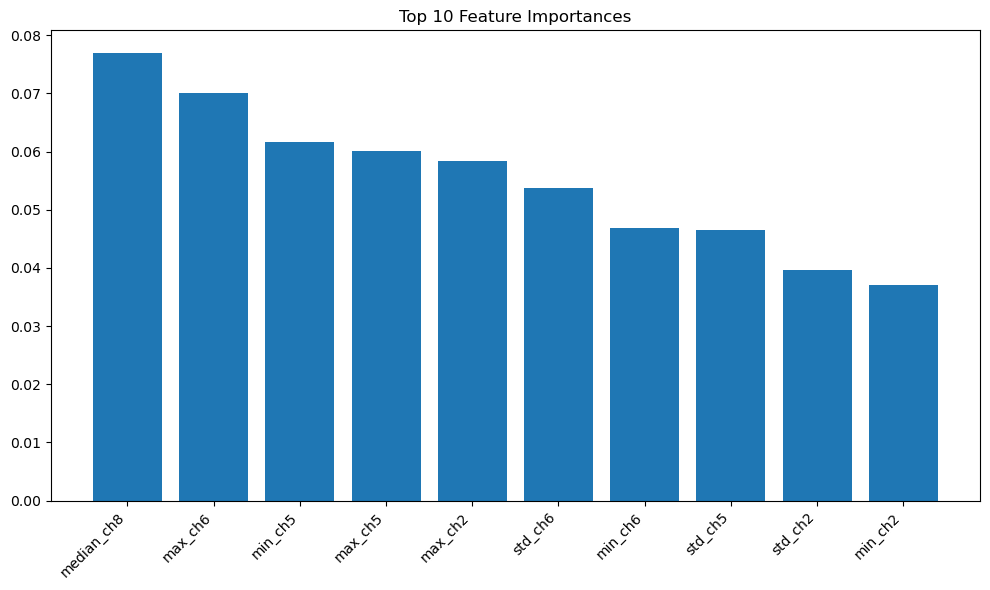

In [11]:
# 7. Evaluate performance
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
label_names = [reverse_label_mapping[i] for i in sorted(reverse_label_mapping)]

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_names))

# 8. Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(clf.classes_)),
    yticks=np.arange(len(clf.classes_)),
    xticklabels=label_names,
    yticklabels=label_names,
    xlabel='Predicted label',
    ylabel='True label',
    title='Confusion Matrix'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout()
plt.show()

# 9. Plot top 10 feature importances
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1][:10]
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(len(indices)), importances[indices])
plt.xticks(
    range(len(indices)),
    [feature_names[i] for i in indices],
    rotation=45,
    ha='right'
)
plt.tight_layout()
plt.show()


### Data Leak Prevention：確保 Data Leak 沒有發生，先將資料分群後再最後續處理

file_label_pairs = [('/Users/bryant_lue/Documents/Data_Tmp/MDS/full/vertical-misalignment/1.78mm/60.6208.csv', 'vertical_misalignment'), ('/Users/bryant_lue/Documents/Data_Tmp/MDS/full/vertical-misalignment/1.78mm/16.7936.csv', 'vertical_misalignment'), ('/Users/bryant_lue/Documents/Data_Tmp/MDS/full/vertical-misalignment/1.78mm/17.408.csv', 'vertical_misalignment'), ('/Users/bryant_lue/Documents/Data_Tmp/MDS/full/vertical-misalignment/1.78mm/55.9104.csv', 'vertical_misalignment'), ('/Users/bryant_lue/Documents/Data_Tmp/MDS/full/vertical-misalignment/1.78mm/54.272.csv', 'vertical_misalignment')]
Total files found: 1951
Label mapping: {'normal': 0, 'imbalance': 1, 'horizontal_misalignment': 2, 'vertical_misalignment': 3, 'overhang_ball': 4, 'overhang_cage': 5, 'overhang_race': 6, 'underhang_ball': 7, 'underhang_cage': 8, 'underhang_race': 9}
Feature names: ['mean_ch1', 'std_ch1', 'min_ch1', 'max_ch1', 'median_ch1', 'mean_ch2', 'std_ch2', 'min_ch2', 'max_ch2', 'median_ch2', 'mean_ch3', '

Extracting features: 100%|██████████| 391/391 [00:52<00:00,  7.44file/s]


                         precision    recall  f1-score   support

                 normal       0.90      0.90      0.90        10
              imbalance       0.97      0.97      0.97        67
horizontal_misalignment       0.95      0.95      0.95        39
  vertical_misalignment       1.00      0.98      0.99        60
          overhang_ball       1.00      1.00      1.00        27
          overhang_cage       0.95      1.00      0.97        38
          overhang_race       1.00      0.97      0.99        38
         underhang_ball       1.00      1.00      1.00        37
         underhang_cage       1.00      1.00      1.00        38
         underhang_race       1.00      1.00      1.00        37

               accuracy                           0.98       391
              macro avg       0.98      0.98      0.98       391
           weighted avg       0.98      0.98      0.98       391



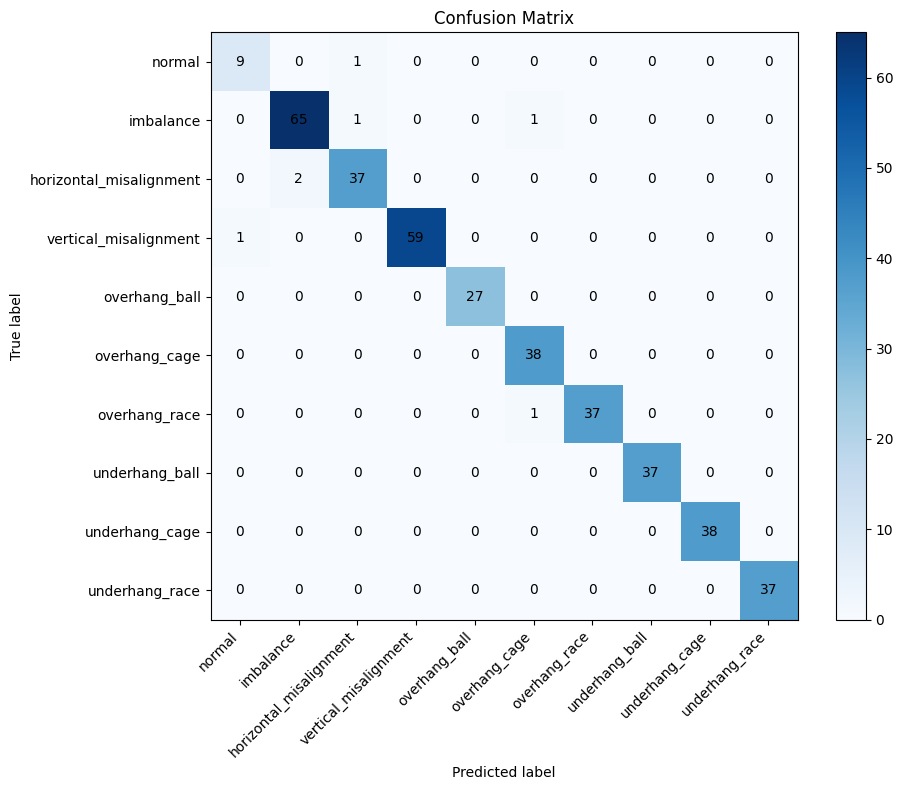

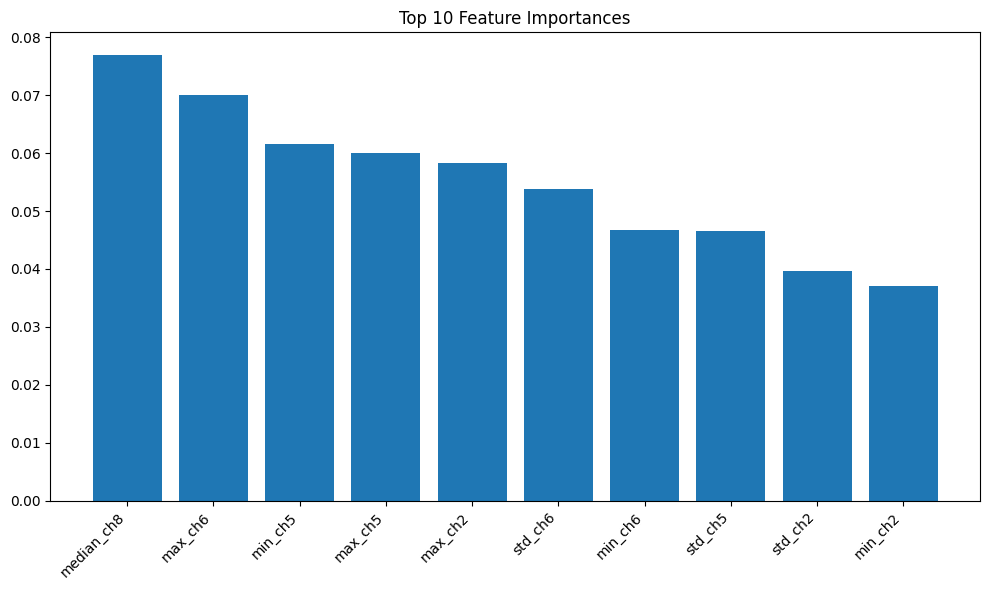

In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. 特徵抽取 function
def extract_features(file_path):
    df = pd.read_csv(file_path, header=None)
    stats = []
    for col in df.columns:
        col_data = df[col]
        stats.extend([
            col_data.mean(),
            col_data.std(),
            col_data.min(),
            col_data.max(),
            col_data.median()
        ])
    return stats

# 2. Pipeline 用的 FeatureExtractor
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        features = []
        for fp in tqdm(X, desc="Extracting features", unit="file"):
            features.append(extract_features(fp))
        return np.array(features)

# 3. 特徵名稱
stats_names = ['mean', 'std', 'min', 'max', 'median']
feature_names = [f"{s}_ch{ch}" for ch in range(1, 9) for s in stats_names]

# 4. 標籤對應
label_mapping = {
    'normal': 0,
    'imbalance': 1,
    'horizontal_misalignment': 2,
    'vertical_misalignment': 3,
    'overhang_ball': 4,
    'overhang_cage': 5,
    'overhang_race': 6,
    'underhang_ball': 7,
    'underhang_cage': 8,
    'underhang_race': 9,
}
fault_name_mapping = {'ball_fault': 'ball', 'cage_fault': 'cage', 'outer_race': 'race'}

# 5. 找出所有檔案路徑、標籤
data_dir = '/Users/bryant_lue/Documents/Data_Tmp/MDS/full'  # 修改成你的資料夾
file_label_pairs = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.csv'):
            full_path = os.path.join(root, file)
            parts = Path(full_path).parts
            found = False
            for part in parts:
                label = part.replace(' ', '_').replace('-', '_').lower()
                if label in label_mapping:
                    file_label_pairs.append((full_path, label))
                    found = True
                    break
            if not found:
                for i in range(len(parts) - 1):
                    parent = parts[i].replace(' ', '_').replace('-', '_').lower()
                    fault_folder = parts[i + 1].replace(' ', '_').replace('-', '_').lower()
                    if fault_folder in fault_name_mapping:
                        fault = fault_name_mapping[fault_folder]
                        joined_label = f"{parent}_{fault}"
                        if joined_label in label_mapping:
                            file_label_pairs.append((full_path, joined_label))
                            found = True
                            break
            if not found:
                raise ValueError(f"Label not in label_mapping for path: {full_path}")
            
# 確認有多少檔案與標籤
print(f"file_label_pairs = {file_label_pairs[:5]}")  # 顯示前5個檔案與標籤
# 確認有多少檔案與標籤
print(f"Total files found: {len(file_label_pairs)}")
# 確認標籤對應
print(f"Label mapping: {label_mapping}")
# 確認特徵名稱
print(f"Feature names: {feature_names}")

# 6. 切分 train/test（這邊只存路徑與標籤）
file_paths = [fp for fp, _ in file_label_pairs]
labels = [label_mapping[label] for _, label in file_label_pairs]

X_train_fp, X_test_fp, y_train, y_test = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# 7. Pipeline 建立
pipe = Pipeline([
    ('extract', FeatureExtractor()),
    ('scale', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# 8. 訓練
pipe.fit(X_train_fp, y_train)

# 9. 預測
y_pred = pipe.predict(X_test_fp)

# 10. 分類報告與混淆矩陣
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
label_names = [reverse_label_mapping[i] for i in sorted(reverse_label_mapping)]

print(classification_report(y_test, y_pred, target_names=label_names))

cm = confusion_matrix(y_test, y_pred, labels=sorted(reverse_label_mapping.keys()))
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(label_names)),
    yticks=np.arange(len(label_names)),
    xticklabels=label_names,
    yticklabels=label_names,
    xlabel='Predicted label',
    ylabel='True label',
    title='Confusion Matrix'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout()
plt.show()

# 11. 特徵重要性視覺化
# Pipeline 裡要取出 feature_importances_ 需這樣取
importances = pipe.named_steps['clf'].feature_importances_
indices = np.argsort(importances)[::-1][:10]
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(len(indices)), importances[indices])
plt.xticks(
    range(len(indices)),
    [feature_names[i] for i in indices],
    rotation=45,
    ha='right'
)
plt.tight_layout()
plt.show()

### Cross Validation

In [4]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Prepare file paths and labels
file_paths = [fp for fp, _ in file_label_pairs]
labels = [label_mapping[label] for _, label in file_label_pairs]

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe, file_paths, labels, cv=cv, scoring='accuracy', n_jobs=1)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy: {:.3f} ± {:.3f}".format(np.mean(cv_scores), np.std(cv_scores)))

Extracting features: 100%|██████████| 390/390 [00:49<00:00,  7.82file/s]

Cross-Validation Scores: [0.98721228 0.99230769 0.98205128 0.98717949 0.98717949]
Mean CV Accuracy: 0.987 ± 0.003


In [8]:
df_cv_scores = pd.DataFrame(cv_scores, columns=['Accuracy'])
df_cv_scores.index.name = 'Fold'
df_cv_scores

,Accuracy
Fold,
0,0.987212
1,0.992308
2,0.982051
3,0.987179
4,0.987179


### Test Size and Accuracy Experiment

Extracting features: 100%|██████████| 1951/1951 [04:01<00:00,  8.07file/s]



Test size: 0.10
X_train.shape = (1755, 40)
y_train.shape = (1755,)
X_test.shape = (196, 40)
y_test.shape = (196,)
Accuracy: 0.9796
                         precision    recall  f1-score   support

                 normal       1.00      0.80      0.89         5
              imbalance       1.00      0.97      0.98        33
horizontal_misalignment       0.95      0.95      0.95        20
  vertical_misalignment       0.94      0.97      0.95        30
          overhang_ball       1.00      1.00      1.00        14
          overhang_cage       1.00      1.00      1.00        19
          overhang_race       1.00      1.00      1.00        19
         underhang_ball       1.00      1.00      1.00        19
         underhang_cage       0.95      1.00      0.97        19
         underhang_race       1.00      1.00      1.00        18

               accuracy                           0.98       196
              macro avg       0.98      0.97      0.97       196
           weighted a

/opt/anaconda3/envs/DS311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/DS311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/DS311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


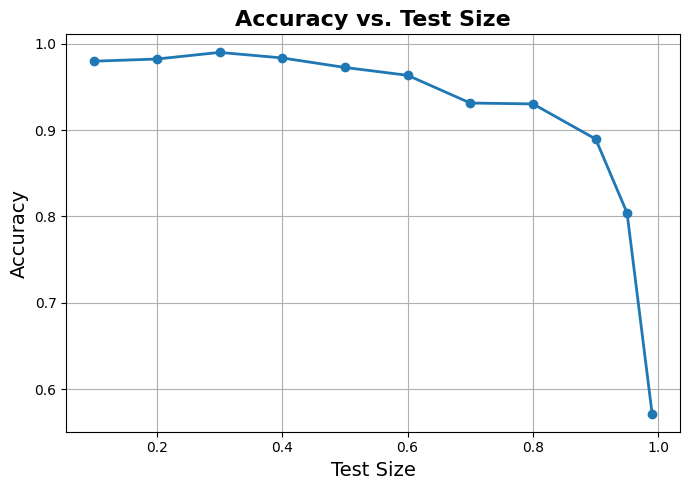

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# 1. Set the path to your unzipped data root directory
data_dir = '/Users/bryant_lue/Documents/Data_Tmp/MDS/full'

# 2. Feature extraction function
def extract_features(file_path):
    df = pd.read_csv(file_path, header=None)
    stats = []
    for col in df.columns:
        col_data = df[col]
        stats.extend([
            col_data.mean(),
            col_data.std(),
            col_data.min(),
            col_data.max(),
            col_data.median()
        ])
    return stats

# 3. Prepare feature names
stats_names = ['mean', 'std', 'min', 'max', 'median']
feature_names = [f"{s}_ch{ch}" for ch in range(1, 9) for s in stats_names]

# 4. Walk through subdirectories, extract features and labels
label_mapping = {
    'normal': 0,
    'imbalance': 1,
    'horizontal_misalignment': 2,
    'vertical_misalignment': 3,
    'overhang_ball': 4,
    'overhang_cage': 5,
    'overhang_race': 6,
    'underhang_ball': 7,
    'underhang_cage': 8,
    'underhang_race': 9,
}
fault_name_mapping = {
    'ball_fault': 'ball',
    'cage_fault': 'cage',
    'outer_race': 'race',
}
file_label_pairs = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.csv'):
            full_path = os.path.join(root, file)
            parts = Path(full_path).parts
            found = False
            for part in parts:
                label = part.replace(' ', '_').replace('-', '_').lower()
                if label in label_mapping:
                    file_label_pairs.append((full_path, label))
                    found = True
                    break
            if not found:
                for i in range(len(parts) - 1):
                    parent = parts[i].replace(' ', '_').replace('-', '_').lower()
                    fault_folder = parts[i + 1].replace(' ', '_').replace('-', '_').lower()
                    if fault_folder in fault_name_mapping:
                        fault = fault_name_mapping[fault_folder]
                        joined_label = f"{parent}_{fault}"
                        if joined_label in label_mapping:
                            file_label_pairs.append((full_path, joined_label))
                            found = True
                            break
            if not found:
                raise ValueError(f"Label not in label_mapping for path: {full_path}")

# 5. Extract features
X, y = [], []
for fp, label in tqdm(file_label_pairs, desc="Extracting features", unit="file"):
    if label not in label_mapping:
        raise ValueError(f"Unrecognized label: {label}")
    X.append(extract_features(fp))
    y.append(label_mapping[label])

X = np.array(X)
y = np.array(y)
df = pd.DataFrame(X, columns=feature_names)
df['label'] = y

# 6. Loop over test sizes and record accuracy
test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
accuracy_scores = []

reverse_label_mapping = {v: k for k, v in label_mapping.items()}
label_names = [reverse_label_mapping[i] for i in sorted(reverse_label_mapping)]

for test_size in test_sizes:
    print(f"\n{'='*30}\nTest size: {test_size:.2f}\n{'='*30}")
    X_train, X_test, y_train, y_test = train_test_split(
        df[feature_names].values,
        df['label'].values,
        test_size=test_size,
        random_state=42,
        stratify=df['label']
    )
    
    print(f"X_train.shape = {X_train.shape}")
    print(f"y_train.shape = {y_train.shape}")
    print(f"X_test.shape = {X_test.shape}")
    print(f"y_test.shape = {y_test.shape}")



    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=label_names))

# 7. Plot accuracy vs. test size
plt.figure(figsize=(7, 5))
plt.plot(test_sizes, accuracy_scores, marker='o', linewidth=2)
plt.title('Accuracy vs. Test Size', fontsize=16, fontweight='bold')
plt.xlabel('Test Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()